# DIABETESTUDY - DIABETES CLASSIFIER & PREDICTOR (by DLC)

---

Autori:
• Donatello Scigliuto
• Luigi Vulcano
• Cristiana Sorrenti (kocri)

---

Questo programma consiste in un sistema di classificazione che, sulla base di misurazioni diagnostiche, prevede se un paziente avrà il diabete.

In particolare, si occupa di:
- Classificare secondo vari algoritmi e valutarne le prestazioni.
- Calcolare la probabilità con cui un soggetto possa avere il diabete.

---

### Librerie

In [21]:
# Installazione librerie necessarie
!pip install pgmpy

In [22]:
# Librerie principali
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Warning control
import warnings
warnings.filterwarnings("ignore")

# Machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Algoritmi di classificazione
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Modelli di classificazione
from pgmpy.estimators import K2Score, HillClimbSearch, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

### Lettura dei dati, panoramica ed analisi esplorativa

In [23]:
# Import del dataset
df = pd.read_csv('diabetes.csv')

# Panoramica dei dati
print('Righe (pazienti) :', df.shape[0])
print('Colonne (features) :', df.shape[1], '\n')
#print('Features :\n', df.columns.tolist())

df.head()  # Mostra breve panoramica del dataset

Righe (pazienti) : 768
Colonne (features) : 9 



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pazienti non diabetici: 500 (% 65.10)
Pazienti diabetici: 268 (% 34.90) 



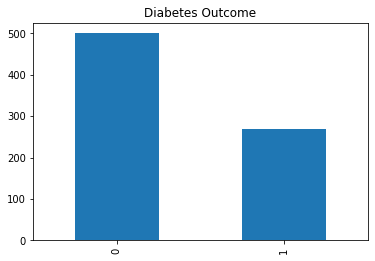

In [24]:
# BILANCIAMENTO DELLE CLASSI

# Proporzione dei non diabetici (0) e diabetici (1): [Numero di (non) diabetici/Numero totale di pazienti]
print('Pazienti non diabetici:', df.Outcome.value_counts()[0], '(% {:.2f})'.format(df.Outcome.value_counts()[0] / df.Outcome.count() * 100))
print('Pazienti diabetici:', df.Outcome.value_counts()[1], '(% {:.2f})'.format(df.Outcome.value_counts()[1] / df.Outcome.count() * 100), '\n')

# Visualizzazione del grafico
df['Outcome'].value_counts().plot(kind='bar').set_title('Diabetes Outcome')
plt.show()

In [25]:
# SOSTITUZIONE DEGLI ZERO CON LA MEDIANA

# Ci sono dei valori zero che influenzeranno sull'accuratezza del training, quindi li sostituisco con il valore mediano
df.Glucose.replace(0, df['Glucose'].median(), inplace=True)
df.BloodPressure.replace(0, df['BloodPressure'].median(), inplace=True)
df.SkinThickness.replace(0, df['SkinThickness'].median(), inplace=True)
df.Insulin.replace(0, df['Insulin'].median(), inplace=True)
df.BMI.replace(0, df['BMI'].median(), inplace=True)

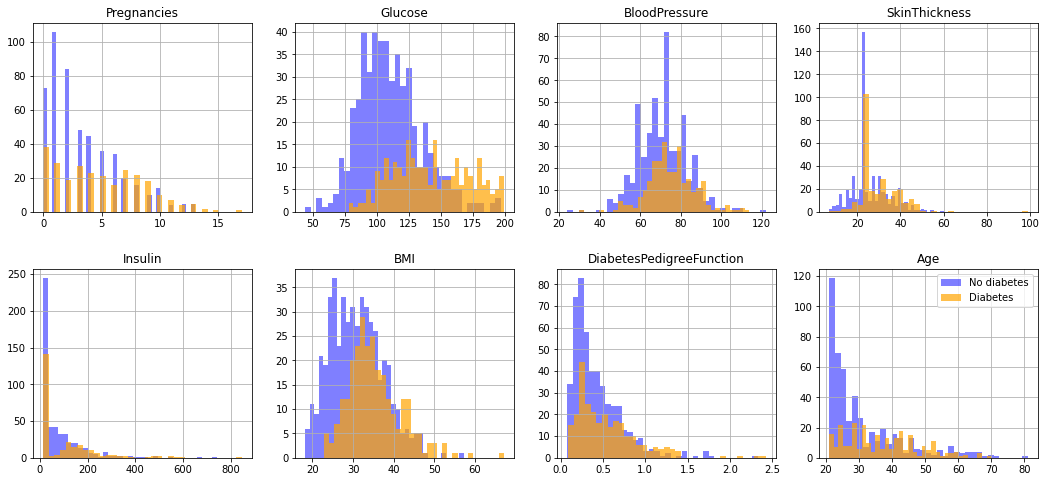

In [26]:
# ANALISI ESPLORATIVA DEI DATI (Exploratory Data Analysis)

# Analisi della distribuzione dei risultati delle feature

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8))
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
    df[df.Outcome==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)  # Distribuzione non diabetici
    df[df.Outcome==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])  # Distribuzione diabetici
    #df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  # Mostra tutto (commentare le due righe precedenti)
    
plt.legend(['No diabetes', 'Diabetes'])  # Tracciamento della legenda
fig.subplots_adjust(hspace=0.3)
plt.show()

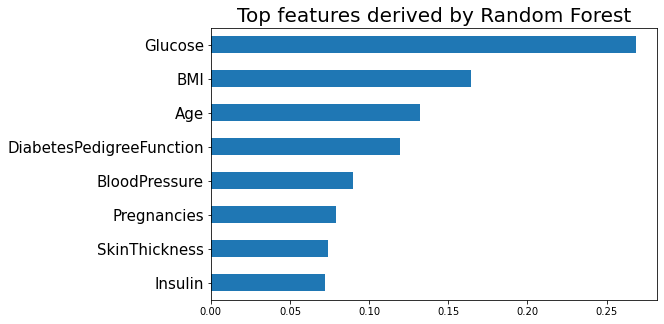

In [27]:
# VERIFICA DELL'IMPORTANZA DELLE FEATURES

# Creazione della feature X e del target y
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Classificatore da utilizzare per la ricerca delle feature principali
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc_model = rfc.fit(X, y)

# Tracciamento delle feature in base alla loro importanza
(pd.Series(rfc_model.feature_importances_, index=X.columns)
    .nlargest(10)  # Numero massimo di feature da visualizzare
    .plot(kind='barh', figsize=[8,5])  # Tipo di grafico e dimensione
    .invert_yaxis())  # Assicuro un ordine decrescente

# Visualizzazione del grafico
plt.title('Top features derived by Random Forest', size=20)
plt.yticks(size=15)
plt.show()

### Model Selection

In [28]:
# MODEL SELECTION: K-FOLD CROSS VALIDATION

# Creazione della feature X e del target y
X = df.to_numpy()
y = df["Outcome"].to_numpy()

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5)  # La classe è in squilibrio, quindi utilizzo Stratified K-Fold

# Classificatori per la valutazione
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()
logit = LogisticRegression()

# Score delle metriche
model = {
        'KNN' : {'accuracy_list': 0.0,
                 'precision_list' : 0.0,
                 'recall_list' : 0.0,
                 'f1_list' : 0.0
        },

        'DecisionTree' : {'accuracy_list': 0.0,
                                    'precision_list' : 0.0,
                                    'recall_list' : 0.0,
                                    'f1_list' : 0.0
        },

        'RandomForest' : {'accuracy_list': 0.0,
                                    'precision_list' : 0.0,
                                    'recall_list' : 0.0,
                                    'f1_list' : 0.0
        },

        'SVC' : {'accuracy_list': 0.0,
                 'precision_list' : 0.0,
                 'recall_list' : 0.0,
                 'f1_list' : 0.0
        },

        'LogisticRegression' : {'accuracy_list': 0.0,
                                'precision_list' : 0.0,
                                'recall_list' : 0.0,
                                'f1_list' : 0.0
        }
}

# K-Fold dei classificatori
for train_index, test_index in kf.split(X, y):

    training_set, testing_set = X[train_index], X[test_index]

    # Dati di train
    data_train = pd.DataFrame(training_set, columns=df.columns)
    X_train = data_train.drop("Outcome", axis=1)
    y_train = data_train.Outcome

    # Dati di test
    data_test = pd.DataFrame(testing_set, columns=df.columns)
    X_test = data_test.drop("Outcome", axis=1)
    y_test = data_test.Outcome

    # Fit dei classificatori
    knn.fit(X_train, y_train)
    dtc.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    logit.fit(X_train, y_train)

    y_pred_knn = knn.predict(X_test)
    y_pred_dtc = dtc.predict(X_test)
    y_pred_rfc = rfc.predict(X_test)
    y_pred_svc = svc.predict(X_test)
    y_pred_logit = logit.predict(X_test)

    # Salvo le metriche del fold nel dizionario
    model['KNN']['accuracy_list'] = (metrics.accuracy_score(y_test, y_pred_knn))
    model['KNN']['precision_list'] = (metrics.precision_score(y_test, y_pred_knn))
    model['KNN']['recall_list'] = (metrics.recall_score(y_test,y_pred_knn))
    model['KNN']['f1_list'] = (metrics.f1_score(y_test, y_pred_knn))

    model['DecisionTree']['accuracy_list'] = (metrics.accuracy_score(y_test, y_pred_dtc))
    model['DecisionTree']['precision_list'] = (metrics.precision_score(y_test, y_pred_dtc))
    model['DecisionTree']['recall_list'] = (metrics.recall_score(y_test, y_pred_dtc))
    model['DecisionTree']['f1_list'] = (metrics.f1_score(y_test, y_pred_knn))

    model['RandomForest']['accuracy_list'] = (metrics.accuracy_score(y_test, y_pred_rfc))
    model['RandomForest']['precision_list'] = (metrics.precision_score(y_test, y_pred_rfc))
    model['RandomForest']['recall_list'] = (metrics.recall_score(y_test, y_pred_rfc))
    model['RandomForest']['f1_list'] = (metrics.f1_score(y_test, y_pred_rfc))

    model['SVC']['accuracy_list'] = (metrics.accuracy_score(y_test, y_pred_svc))
    model['SVC']['precision_list'] = (metrics.precision_score(y_test, y_pred_svc))
    model['SVC']['recall_list'] = (metrics.recall_score(y_test, y_pred_svc))
    model['SVC']['f1_list'] = (metrics.f1_score(y_test, y_pred_svc))

    model['LogisticRegression']['accuracy_list'] = (metrics.accuracy_score(y_test, y_pred_logit))
    model['LogisticRegression']['precision_list'] = (metrics.precision_score(y_test, y_pred_logit))
    model['LogisticRegression']['recall_list'] = (metrics.recall_score(y_test, y_pred_logit))
    model['LogisticRegression']['f1_list'] = (metrics.f1_score(y_test, y_pred_logit))

# Modello di rapporto
def model_report(model):

    df_models = []

    for clf in model:
        df_model = pd.DataFrame({'model'        : [clf],
                                 'accuracy'     : [np.mean(model[clf]['accuracy_list'])],
                                 'precision'    : [np.mean(model[clf]['precision_list'])],
                                 'recall'       : [np.mean(model[clf]['recall_list'])],
                                 'f1score'      : [np.mean(model[clf]['f1_list'])]
                                 })
        
        df_models.append(df_model)
        
    return df_models

# Visualizzazione della tabella con le metriche
df_models_concat = pd.concat(model_report(model), axis=0).reset_index()  # Concatenazione dei modelli
df_models_concat = df_models_concat.drop('index', axis=1)  # Rimozione dell'indice
df_models_concat  # Visualizzazione della tabella

,model,accuracy,precision,recall,f1score
0,KNN,0.679739,0.534483,0.584906,0.558559
1,DecisionTree,0.712418,0.595745,0.528302,0.558559
2,RandomForest,0.758170,0.681818,0.566038,0.618557
3,SVC,0.771242,0.750000,0.509434,0.606742
4,LogisticRegression,0.758170,0.710526,0.509434,0.593407


### Rete bayesiana

In [29]:
# CREAZIONE DELLA RETE BAYESIANA

# Conversione di tutti i valori all'interno del dataframe in interi
df_int = np.array(df, dtype=int)
df = pd.DataFrame(df_int, columns=df.columns)

# Creazione della feature X e del target y
X_train = df
y_train = df["Outcome"]

# Creazione della struttura della rete
k2 = K2Score(X_train)
hc_k2 = HillClimbSearch(X_train)
k2_model = hc_k2.estimate(scoring_method=k2)

# Creazione della rete
bNet = BayesianNetwork(k2_model.edges())
bNet.fit(df, estimator=MaximumLikelihoodEstimator)

# Visualizzazione dei nodi e degli archi
print('\033[1m' + '\nNodi della rete:\n' + '\033[0m', bNet.nodes)
print('\033[1m' + '\nArchi della rete:\n' + '\033[0m', bNet.edges)

  0%|          | 0/1000000 [00:00<?, ?it/s]


Nodi della rete:
 ['Pregnancies', 'Age', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', 'Outcome', 'Glucose', 'BMI']

Archi della rete:
 [('Pregnancies', 'Age'), ('Age', 'Outcome'), ('Insulin', 'SkinThickness'), ('DiabetesPedigreeFunction', 'Outcome'), ('DiabetesPedigreeFunction', 'Glucose'), ('Outcome', 'Glucose'), ('Outcome', 'BMI')]


In [30]:
# CALCOLO DELLA PROBABILITÀ

# Calcolo della probabilità per un soggetto presumibilmente non diabetico (0) ed uno diabetico (1) di avere il diabete

# Eliminazione delle variabili ininfluenti
data = VariableElimination(bNet)

# Soggetto potenzialmente non diabetico
notDiabetic = data.query(variables = ['Outcome'],
                         evidence = { 'Pregnancies' : 2, 'Glucose' : 100, 'SkinThickness' : 30, 'Age' : 25 })

print('\nProbabilità per un soggetto potenzialmente non diabetico:')
print(notDiabetic, '\n')

# Soggetto potenzialmente diabetico
diabetic = data.query(variables = ['Outcome'],
                      evidence = { 'Pregnancies' : 5, 'Glucose' : 150, 'SkinThickness' : 45, 'Age' : 50 })

print('\nProbabilità per un soggetto potenzialmente diabetico:')
print(diabetic)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Probabilità per un soggetto potenzialmente non diabetico:
+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.8344 |
+------------+----------------+
| Outcome(1) |         0.1656 |
+------------+----------------+ 



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Probabilità per un soggetto potenzialmente diabetico:
+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.4286 |
+------------+----------------+
| Outcome(1) |         0.5714 |
+------------+----------------+
